In [21]:
import torch 
import torch.nn as nn
import lightning as L

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet
from BalticRiverPrediction.BaltNet import LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset

In [2]:
# Our GPU has tensor cores, hence mixed precision training is enabled
# see https://sebastianraschka.com/blog/2023/llm-mixed-precision-copy.html
# for more

torch.set_float32_matmul_precision("medium")

In [3]:
# set random seed for reproducibility
L.pytorch.seed_everything(123)

Global seed set to 123


123

Under `data/` one subdirectory stores the atmospheric data, the other the runoff data.

In [4]:
# Loads the atmospheric data in batches
dataLoader = AtmosphereDataModule(
datapath="/silor/boergel/paper/runoff_prediction/data",
batch_size=64
)

In [5]:
modelParameters = {
"input_dim":30, # timesteps
"hidden_dim":1, # Channels -> right now only precipitation
"kernel_size":(3,3), # applied for spatial convolutions
"num_layers":2, # number of convLSTM layers
"batch_first":True, # first index is batch
"bias":True, 
"return_all_layers": False, 
"dimensions": (191, 206) # dimensions of atmospheric forcing
}

num_epochs = 50

In [6]:
callbacks = [
    ModelCheckpoint(
        dirpath="/silor/boergel/paper/runoff_prediction/data/modelWeights/",
        filename="BaltNetTopOne",
        save_top_k=1,
        mode="max",
        monitor="val_mse",
        save_last=True
    )
]

In [7]:
pyTorchBaltNet = BaltNet(modelPar=modelParameters)

In [11]:
LighningBaltNet = LightningModel.load_from_checkpoint(
    checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/BaltNetTopOne.ckpt",
    learning_rate=1e-3,
    model=pyTorchBaltNet
)

In [22]:
data = AtmosphericDataset(
    datapath="/silor/boergel/paper/runoff_prediction/data"
    )

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 97/97 [07:40<00:00,  4.75s/it]


In [23]:
predict_dataloader = DataLoader(
    data,
    batch_size=32,
    shuffle=False
    )

In [25]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
predictions = trainer.predict(LighningBaltNet, dataloaders=predict_dataloader)


Missing logger folder: /silor/boergel/paper/runoff_prediction/src/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 616/616 [00:29<00:00, 21.06it/s]


In [32]:
concatenated_predictions = torch.cat(predictions, dim=0)

In [39]:
rescaledRunoffData = concatenated_predictions*data.runoffData[1].data+data.runoffData[0].data

In [41]:
import matplotlib.pyplot as plt

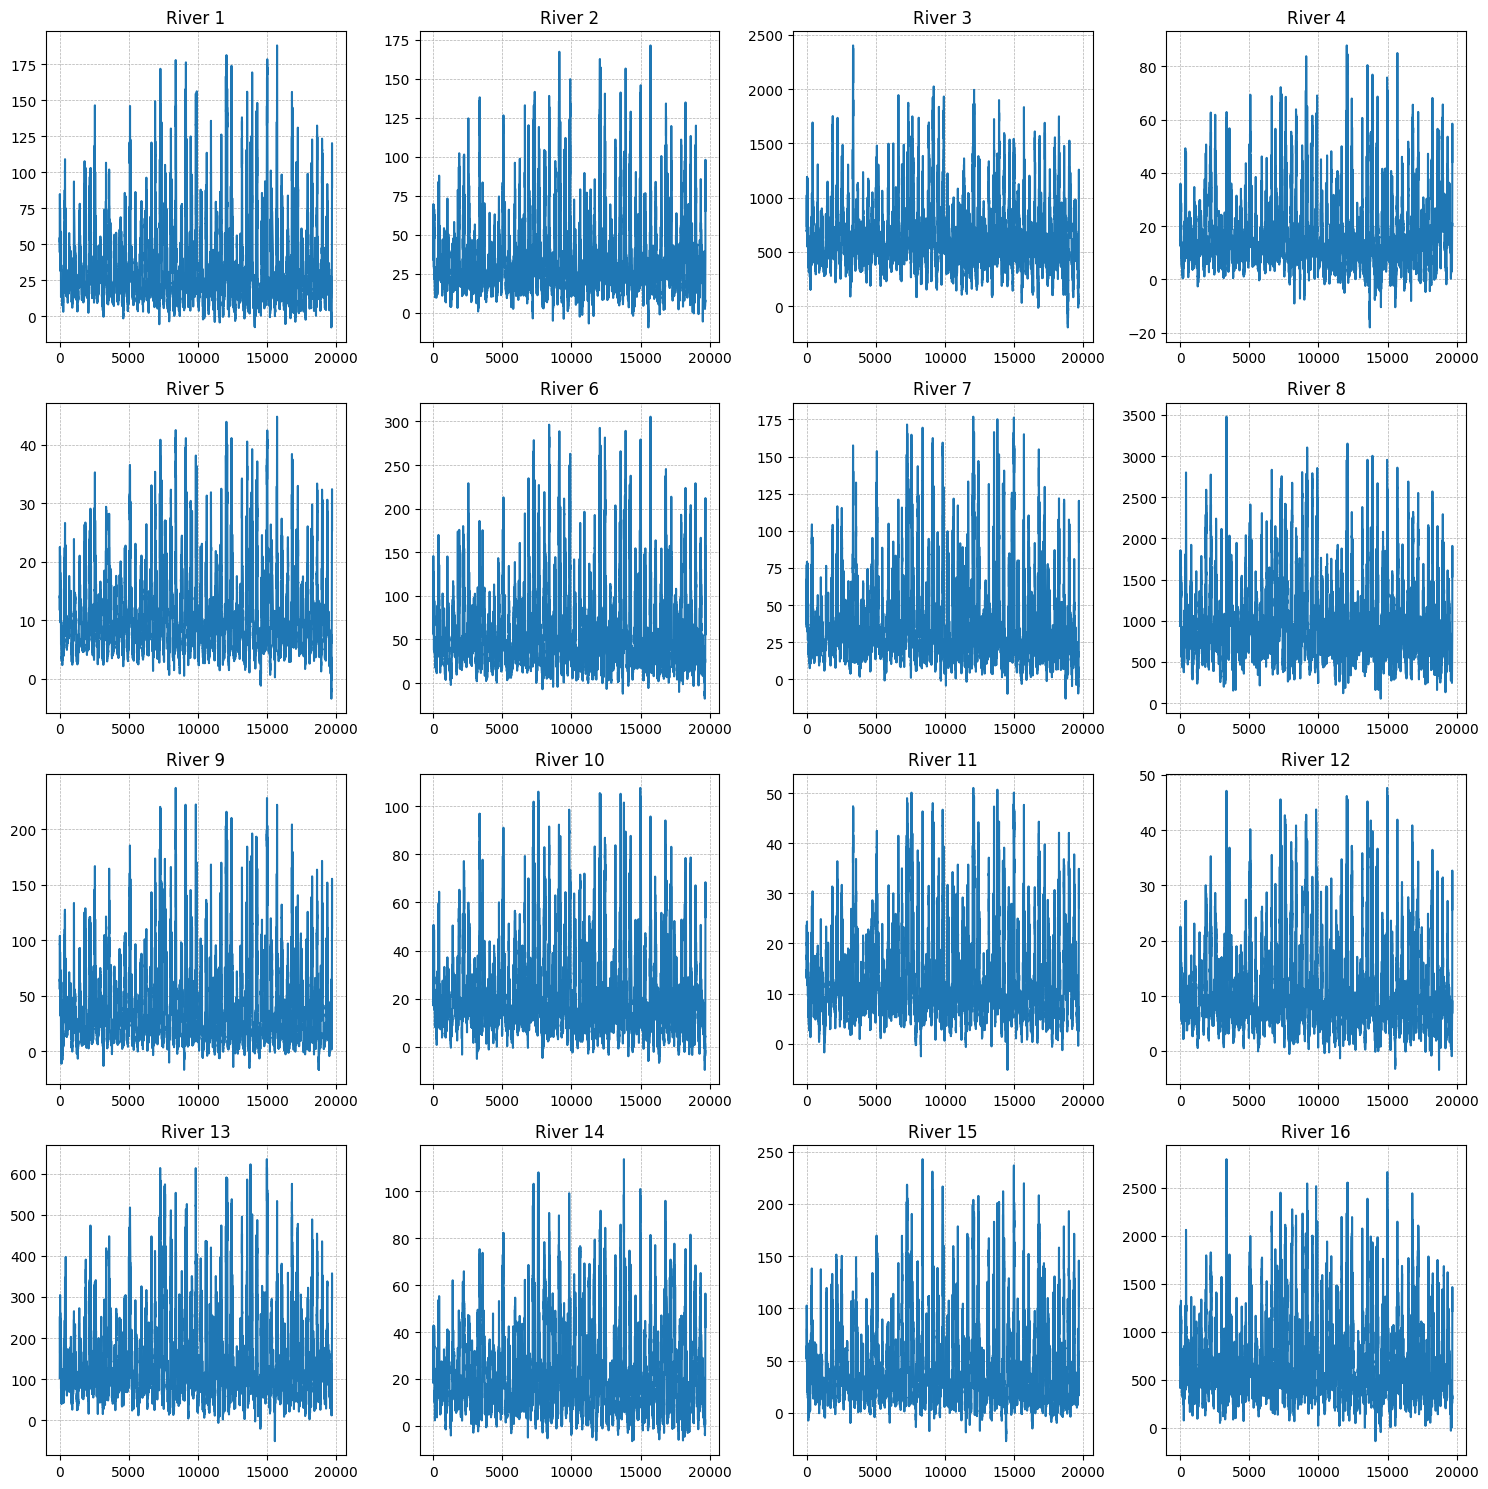

In [48]:
f, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    ax.set_title(f"River {i+1}")
    ax.plot(rescaledRunoffData[:,i])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


Store timestamp and compare to original rivers.